<a href="https://colab.research.google.com/github/clemed92/Diamonds-price/blob/main/XIE_Chlo%C3%A9_EDOUARD_Cl%C3%A9ment_final_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Projet AAA

This project is a key component of the "Algorithms and Machine Learning" course at IMT Atlantique in Nantes, France. Our objective is to build a machine learning model capable of predictiong diamonds price based on ten categories. This problem is framed as a refression task, using supervised and batch learning approches.

*Dataset link* :https://www.kaggle.com/datasets/amirhosseinmirzaie/diamonds-price-dataset



In [ ]:
# Scikit-Learn
import sklearn
from sklearn.model_selection import train_test_split,GridSearchCV, cross_val_score,learning_curve,KFold
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer,make_column_selector
from sklearn.preprocessing import StandardScaler,OneHotEncoder, OrdinalEncoder
from sklearn.linear_model import LinearRegression,Ridge,RidgeCV,ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor,VotingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.neighbors import KNeighborsRegressor

# Common imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix

#seaborn
import seaborn as sns



# Get the Data

## Data exploration

Taking a Quick Look at the Data Structure

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/clemed92/Diamonds-price/refs/heads/main/diamonds.csv')

In [ ]:
df.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


All instances are useful in our case.


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   carat    50000 non-null  float64
 1   cut      50000 non-null  object 
 2   color    50000 non-null  object 
 3   clarity  50000 non-null  object 
 4   depth    50000 non-null  float64
 5   table    50000 non-null  float64
 6   price    50000 non-null  int64  
 7   x        50000 non-null  float64
 8   y        50000 non-null  float64
 9   z        50000 non-null  float64
dtypes: float64(6), int64(1), object(3)
memory usage: 3.8+ MB


There are 10 columns to caracterize the diamond. For each instance, there are 50 000 values. Carat, depth, table, x, y and z are represented with float. Price is an integer. Cut, color and clarity are categorical features.  

Now, let's look if there are any missing values.

In [ ]:
print("Missing values")
missing_values = df.isnull().sum()
print(missing_values[missing_values > 0]) #Show only columns with missing values

Missing values
Series([], dtype: int64)




With the code, we can see that there are no missing or null values in the table.

In [ ]:
#Identify rows with zero values in dimensions (x,y,z)
zero_dimensions = df[(df['x']==0 | (df['y']==0 | (df['z']==0)))]

summary_stats = df.describe()

zero_dimensions, summary_stats

(       carat        cut color clarity  depth  table  price    x     y    z
 10310   1.07      Ideal     F     SI2   61.6   56.0   4954  0.0  6.62  0.0
 11038   1.00  Very Good     H     VS2   63.3   53.0   5139  0.0  0.00  0.0
 14731   1.14       Fair     G     VS1   57.5   67.0   6381  0.0  0.00  0.0
 22721   1.56      Ideal     G     VS2   62.2   54.0  12800  0.0  0.00  0.0
 24336   1.20    Premium     D    VVS1   62.1   59.0  15686  0.0  0.00  0.0
 25439   2.25    Premium     H     SI2   62.8   59.0  18034  0.0  0.00  0.0
 45910   0.71       Good     F     SI2   64.1   60.0   2130  0.0  0.00  0.0,
               carat         depth         table         price             x  \
 count  50000.000000  50000.000000  50000.000000  50000.000000  50000.000000   
 mean       0.799444     61.753006     57.457830   3944.805440      5.734403   
 std        0.475173      1.431088      2.232092   3997.938105      1.123077   
 min        0.200000     43.000000     43.000000    326.000000      0.0

There are zeros   
it means that the diamond does not exist or has no size, we can not treat the problem so we delete these lines

In [ ]:
#Drop row with zero values
df_cleaned= df[(df['x']!=0) & (df['y']!=0) & (df['z']!=0)]
df_cleaned.shape

(49983, 10)

In [ ]:
data_object = df_cleaned.select_dtypes('object')
for col in data_object.columns:
  print(df_cleaned[col].value_counts())

cut
Ideal        19935
Premium      12797
Very Good    11203
Good          4554
Fair          1494
Name: count, dtype: int64
color
G    10444
E     9085
F     8861
H     7707
D     6223
I     5057
J     2606
Name: count, dtype: int64
clarity
SI1     12114
VS2     11400
SI2      8511
VS1      7578
VVS2     4694
VVS1     3368
IF       1632
I1        686
Name: count, dtype: int64


We can't see the different categories for each column :

1.  Cut could be represented by : Ideal, Premium, Very good, Good or Fair.
2.  Color could be represented by : D, E, F, G, H, I, J. It represents the purity of the color.
3.  Clarity could be represented by : SI1, VS2, SI2, VS1, VVS2, VVS1, IFF, I1.


Now let's see the main measures of the numerical columns of the table.

In [ ]:
df_cleaned.describe()

,carat,depth,table,price,x,y,z
count,49983.000000,49983.000000,49983.000000,49983.000000,49983.000000,49983.000000,49983.000000
mean,0.799214,61.753088,57.457566,3943.076086,5.734869,5.738302,3.542260
std,0.474970,1.430864,2.231614,3995.956857,1.120889,1.143739,0.704162
min,0.200000,43.000000,43.000000,326.000000,3.730000,3.680000,1.070000
25%,0.400000,61.000000,56.000000,951.000000,4.710000,4.720000,2.910000
50%,0.700000,61.800000,57.000000,2409.000000,5.700000,5.710000,3.530000
75%,1.040000,62.500000,59.000000,5347.000000,6.540000,6.540000,4.040000
max,5.010000,79.000000,95.000000,18823.000000,10.740000,58.900000,31.800000


Let's plot the boxplot of numerical characteristics to detect outliers

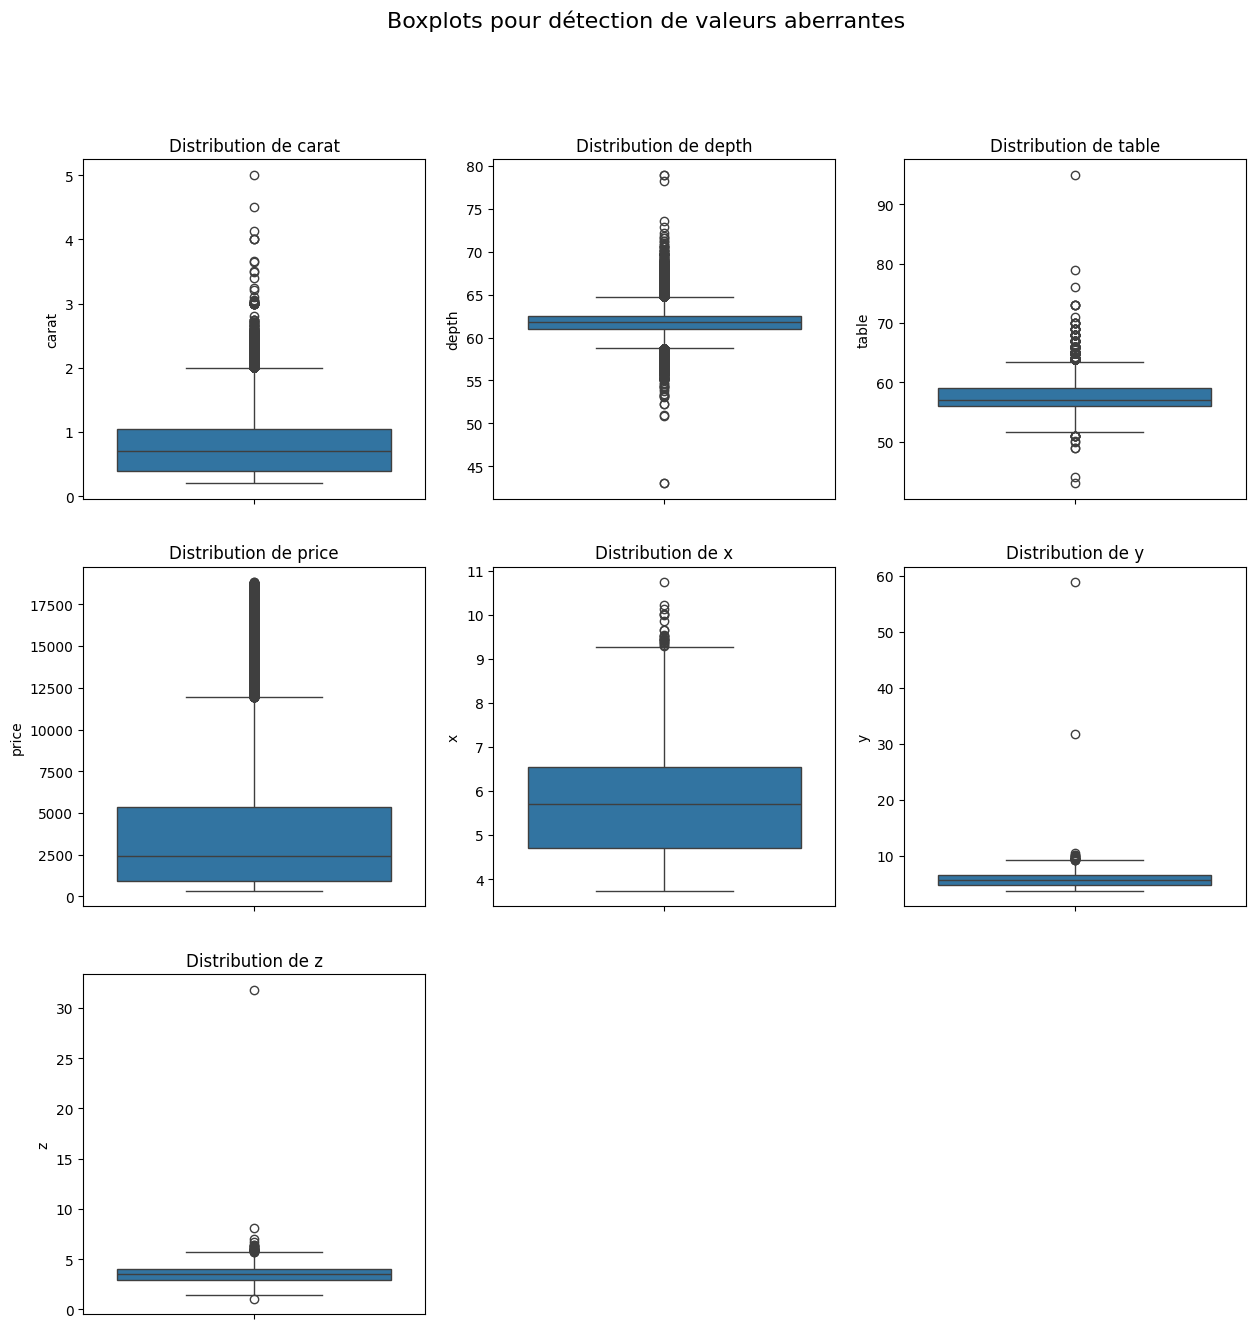

In [ ]:
numerical_features = ['carat','depth','table','price','x','y','z']

fig,axes = plt.subplots(3,3,figsize=(15,15))
fig.suptitle("Boxplots pour détection de valeurs aberrantes", fontsize=16)

for i in range (0, len(numerical_features)):
  sns.boxplot(df_cleaned[numerical_features[i]], ax=axes[i//3,i%3])
  axes [i//3,i%3].set_title(f'Distribution de {numerical_features[i]}')

for j in range (len(numerical_features),9): # supprime les figures inutiles
  axes[j//3,j%3].axis('off')





With the boxplots, we can see that there are a few cradling values, particularly in the distributions of 'y' and 'z'.  
In our case, these extreme values are legitimate because they represent real cases, we really have expensive diamonds in our dataset. We don't have a lot of these values and our dataset is huge so we don't have to delete them because they won't interfere a lot.

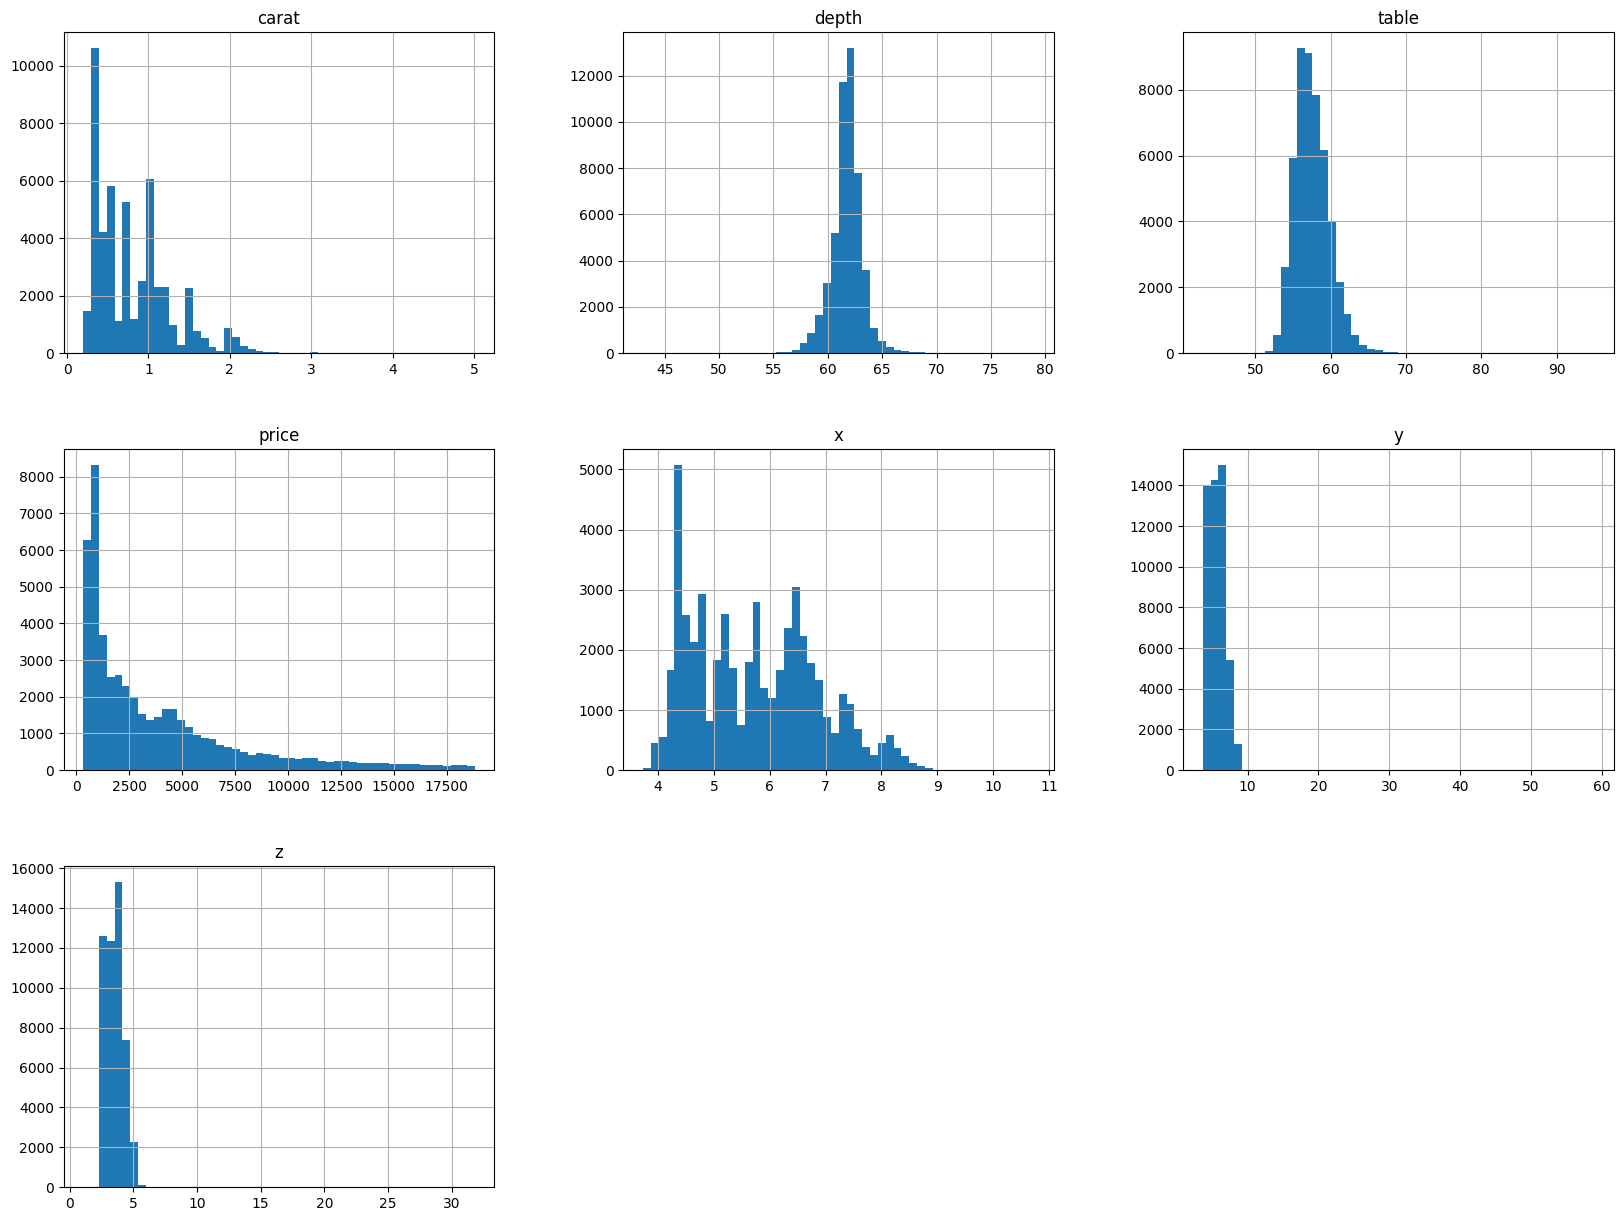

In [ ]:
df_cleaned.hist(bins=50, figsize=(20,15))
plt.show()

Comments :
- depth and table values are between 50 and 70 while x, y and z values are under 10
-price seems to follow a reverse expennentiel districution
-depth seems to follow a normal distribution
- table seems to follow a chi 2 distribution

Now let's look at the distribution of objects by price:

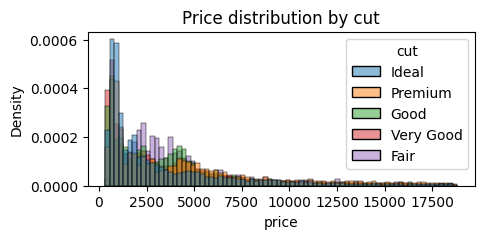

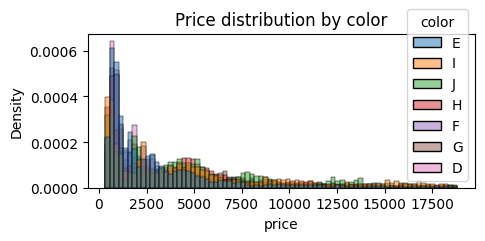

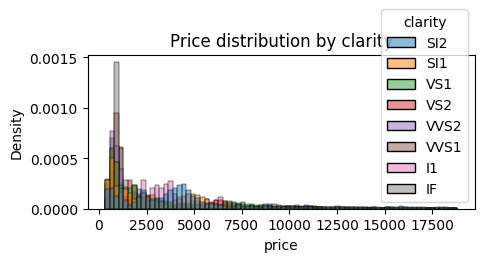

In [ ]:
for col in data_object :
  plt.figure(figsize=(5,2))
  sns.histplot(
      data=df_cleaned.query(f"{col}=={df_cleaned[col].unique().tolist()}"),
      x="price",
      hue= col,
      stat = "density",
      common_norm=False,
  );
  plt.title(f"Price distribution by {col}")
  plt.show

We note that the majority of values in these 3 curves are between 0 and 5000 euros.  
What's more, there are certain categories that are found more in certain price brackets, notably for 'cut', with more 'Premium' than others over 5000 euros.
In this way, the various column categories can be linked to the diamond price.

##Discover and Visualize the Data to Gain Insights

###Visualizing Data

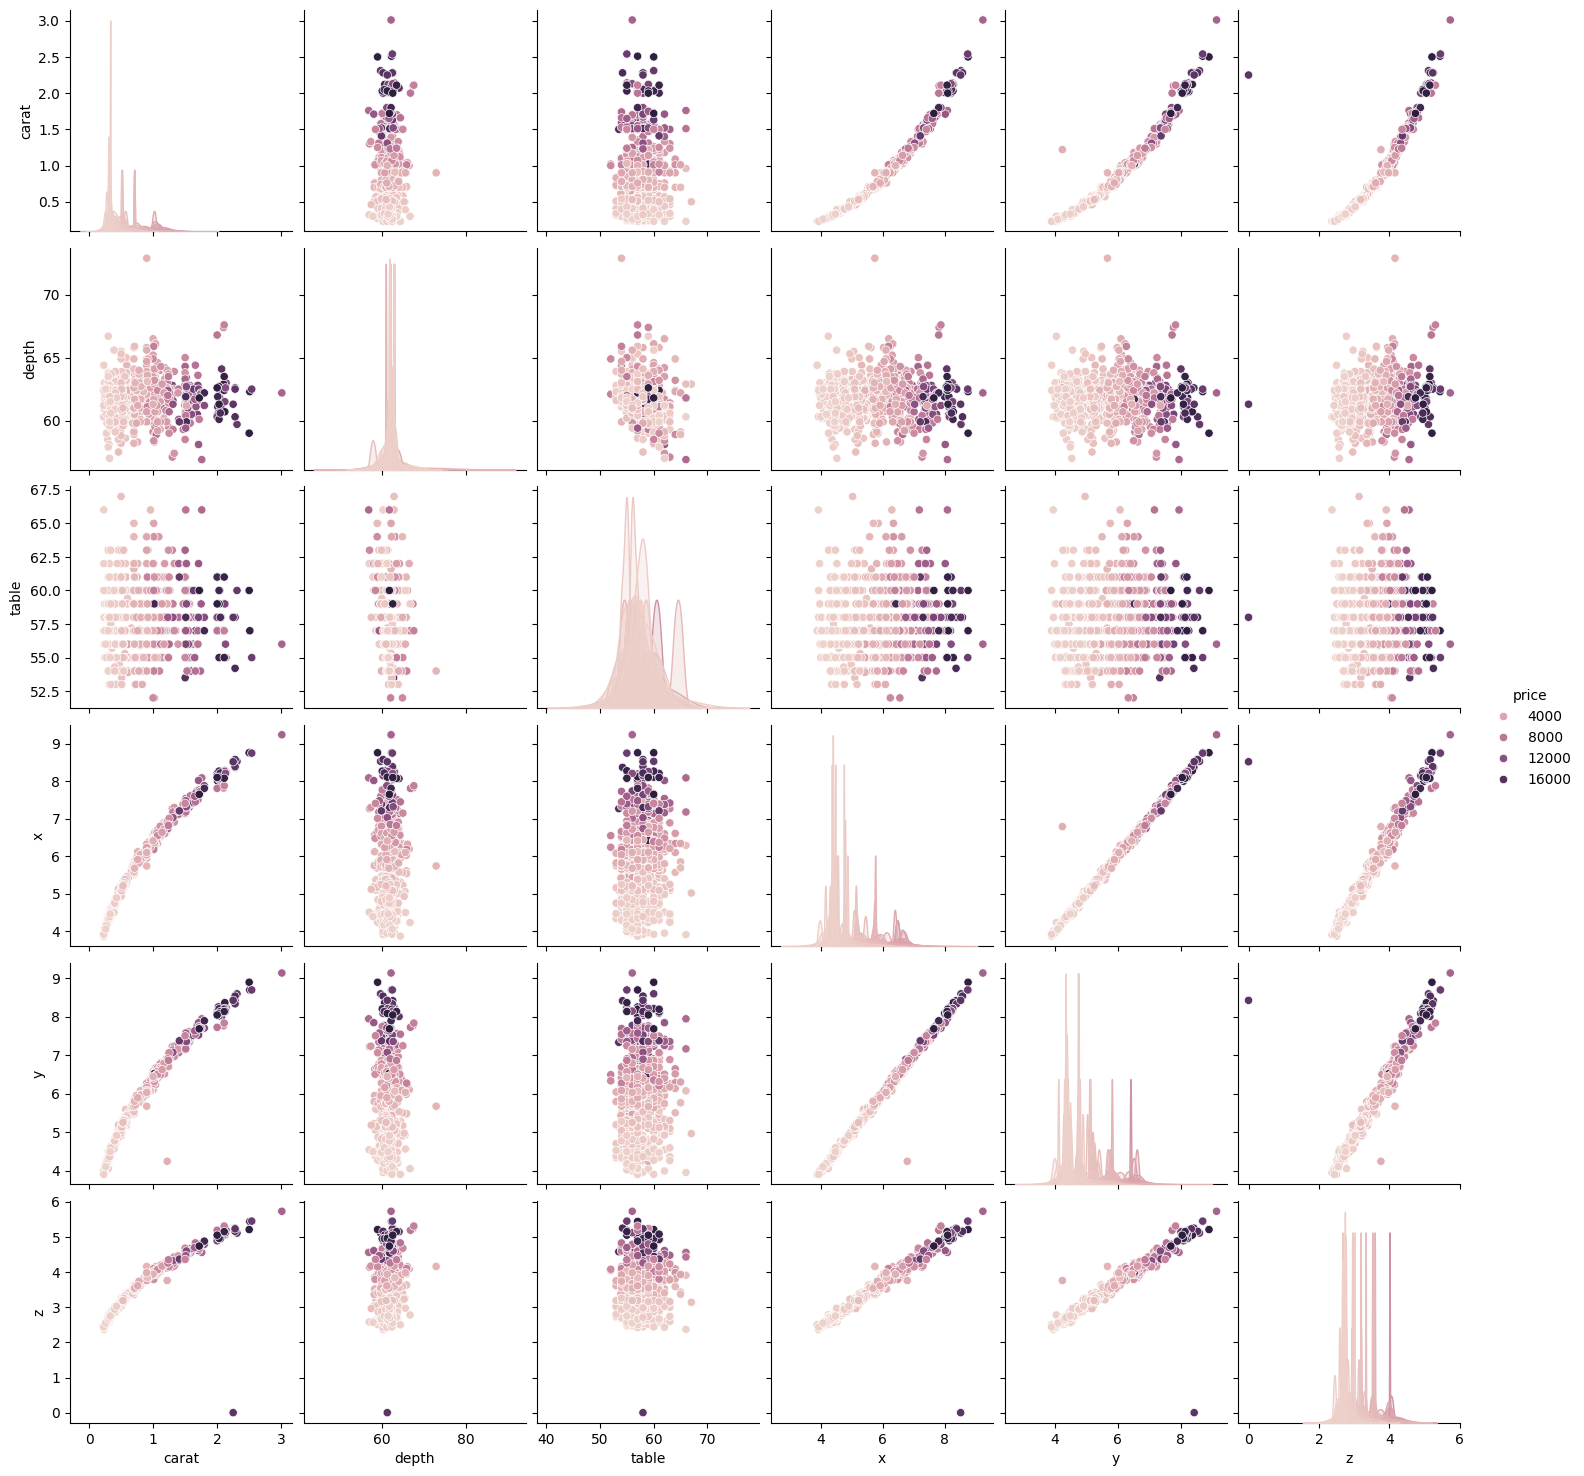

In [ ]:
features = ['carat','cut','color','clarity','depth','table','price','x','y','z']
sns.pairplot(df[features].sample(1000),hue='price')

In a first approach, these graphs allow us to see graphically the correlations between the different columns, as well as with the price in parallel. We will now carry out a more detailed study to determine the links between all these characteristics.  
Once again, we see some extreme values as well as clusters.

###Looking for Correlations



**Correlation in all the dataset**

In [ ]:
corr_matrix = df_cleaned.select_dtypes(['float64','int64']).corr()
print(corr_matrix)

          carat     depth     table     price         x         y         z
carat  1.000000  0.027716  0.183694  0.921815  0.977687  0.952244  0.959792
depth  0.027716  1.000000 -0.292930 -0.012848 -0.025489 -0.029727  0.094485
table  0.183694 -0.292930  1.000000  0.129987  0.197875  0.185907  0.154473
price  0.921815 -0.012848  0.129987  1.000000  0.887742  0.866840  0.867412
x      0.977687 -0.025489  0.197875  0.887742  1.000000  0.973220  0.974266
y      0.952244 -0.029727  0.185907  0.866840  0.973220  1.000000  0.954284
z      0.959792  0.094485  0.154473  0.867412  0.974266  0.954284  1.000000


<Figure size 800x800 with 0 Axes>

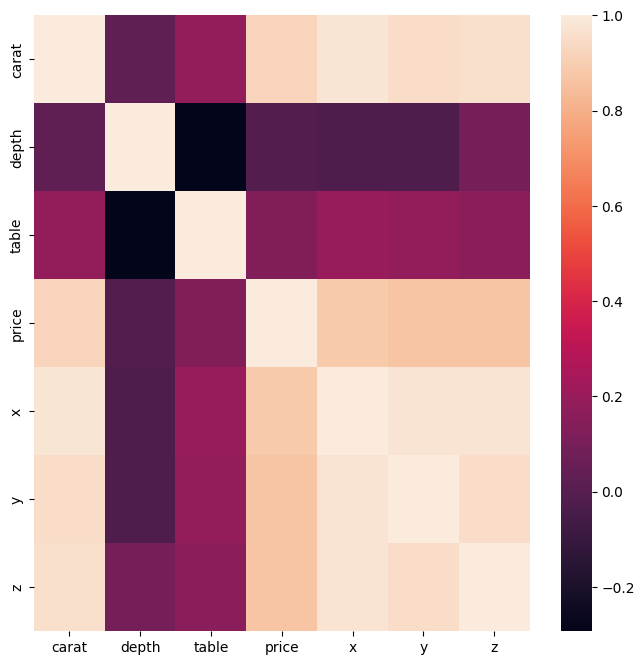

<Figure size 800x800 with 0 Axes>

In [ ]:
plt.figure(figsize=(8,8))
sns.heatmap(corr_matrix)
plt.figure(figsize=(8,8))

With this graph we can easily see the correlation coefficient between the different instances. Some instances don't seem to be linked at all, like 'table' and 'depth', and some are strongly linked, like 'x' 'y' and 'z'.

array([[<Axes: xlabel='carat', ylabel='carat'>,
        <Axes: xlabel='depth', ylabel='carat'>,
        <Axes: xlabel='table', ylabel='carat'>,
        <Axes: xlabel='price', ylabel='carat'>,
        <Axes: xlabel='x', ylabel='carat'>,
        <Axes: xlabel='y', ylabel='carat'>,
        <Axes: xlabel='z', ylabel='carat'>],
       [<Axes: xlabel='carat', ylabel='depth'>,
        <Axes: xlabel='depth', ylabel='depth'>,
        <Axes: xlabel='table', ylabel='depth'>,
        <Axes: xlabel='price', ylabel='depth'>,
        <Axes: xlabel='x', ylabel='depth'>,
        <Axes: xlabel='y', ylabel='depth'>,
        <Axes: xlabel='z', ylabel='depth'>],
       [<Axes: xlabel='carat', ylabel='table'>,
        <Axes: xlabel='depth', ylabel='table'>,
        <Axes: xlabel='table', ylabel='table'>,
        <Axes: xlabel='price', ylabel='table'>,
        <Axes: xlabel='x', ylabel='table'>,
        <Axes: xlabel='y', ylabel='table'>,
        <Axes: xlabel='z', ylabel='table'>],
       [<Axes: xlabel='ca

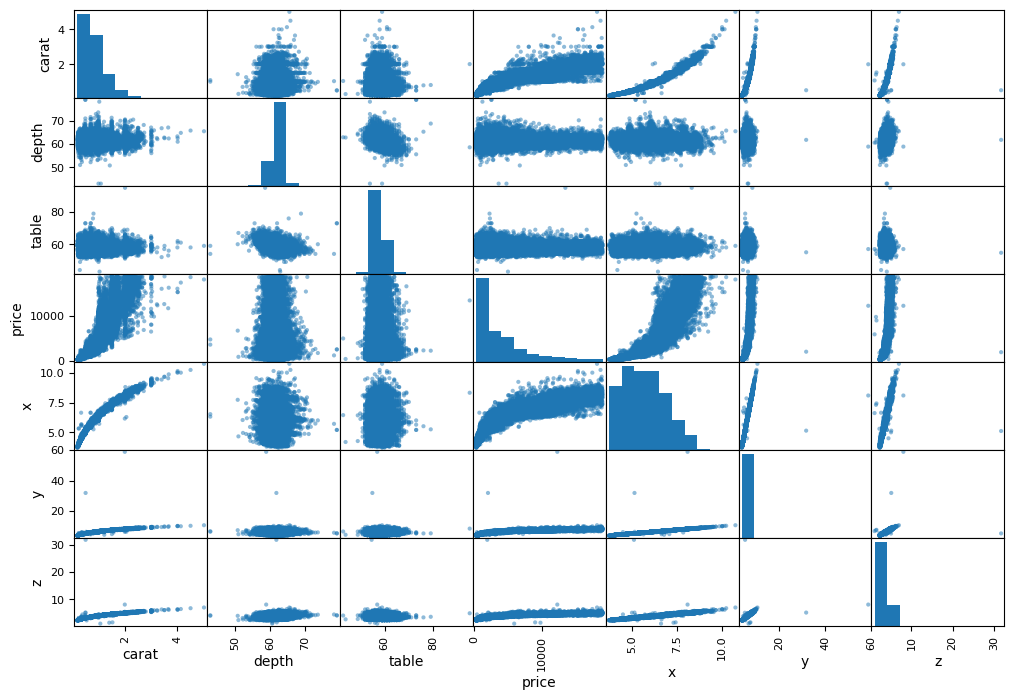

In [ ]:
scatter_matrix(df_cleaned[numerical_features], figsize=(12,8))


We note that 'carat', 'x', 'y' and 'z' are strongly correlated with each other, and also with price. To ease complexity by losing as little information as possible, we decide to remove the carat column, and mix the x, y and z dimensions into a single column: volume =  x*y*z.

In [ ]:
if all(col in df_cleaned.columns for col in ['x', 'y', 'z']):
  df_cleaned['volume']=df_cleaned['x'] * df_cleaned['y'] * df_cleaned['z']
  to_drop=['carat','x','y','z']
  df_cleaned=df_cleaned.drop(to_drop,axis=1)

print(df_cleaned)

             cut color clarity  depth  table  price      volume
0          Ideal     E     SI2   61.5   55.0    326   38.202030
1        Premium     E     SI1   59.8   61.0    326   34.505856
2           Good     E     VS1   56.9   65.0    327   38.076885
3        Premium     I     VS2   62.4   58.0    334   46.724580
4           Good     J     SI2   63.3   58.0    335   51.917250
...          ...   ...     ...    ...    ...    ...         ...
49995      Ideal     D     SI1   60.8   57.0   2757  115.920000
49996       Good     D     SI1   63.1   55.0   2757  118.110175
49997  Very Good     D     SI1   62.8   60.0   2757  114.449728
49998    Premium     H     SI2   61.0   58.0   2757  140.766120
49999      Ideal     D     SI2   62.2   55.0   2757  124.568444

[49983 rows x 7 columns]


<ipython-input-17-964aa9503878>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['volume']=df_cleaned['x'] * df_cleaned['y'] * df_cleaned['z']


In [ ]:
#Calcul of the new corr_matrix with the volume
corr_matrix = df_cleaned.select_dtypes(['float64','int64']).corr()
print(corr_matrix)

           depth     table     price    volume
depth   1.000000 -0.292930 -0.012848  0.008191
table  -0.292930  1.000000  0.129987  0.169550
price  -0.012848  0.129987  1.000000  0.903099
volume  0.008191  0.169550  0.903099  1.000000


array([[<Axes: xlabel='depth', ylabel='depth'>,
        <Axes: xlabel='table', ylabel='depth'>,
        <Axes: xlabel='price', ylabel='depth'>,
        <Axes: xlabel='volume', ylabel='depth'>],
       [<Axes: xlabel='depth', ylabel='table'>,
        <Axes: xlabel='table', ylabel='table'>,
        <Axes: xlabel='price', ylabel='table'>,
        <Axes: xlabel='volume', ylabel='table'>],
       [<Axes: xlabel='depth', ylabel='price'>,
        <Axes: xlabel='table', ylabel='price'>,
        <Axes: xlabel='price', ylabel='price'>,
        <Axes: xlabel='volume', ylabel='price'>],
       [<Axes: xlabel='depth', ylabel='volume'>,
        <Axes: xlabel='table', ylabel='volume'>,
        <Axes: xlabel='price', ylabel='volume'>,
        <Axes: xlabel='volume', ylabel='volume'>]], dtype=object)

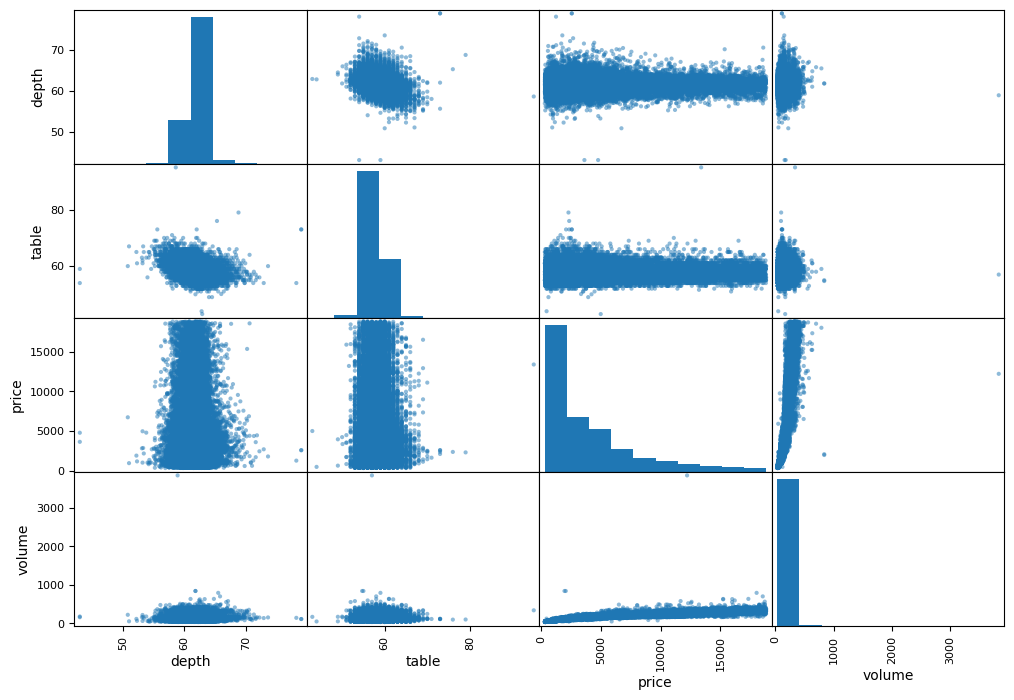

In [ ]:
new_numerical_features=['depth','table','price','volume']
scatter_matrix(df_cleaned[new_numerical_features], figsize=(12,8))

**Correlation with our target**

In [ ]:
numerical_df=df_cleaned.select_dtypes(['number'])
corr_matrix=numerical_df.corr()
corr_matrix['price'].sort_values(ascending=False)

,price
price,1.000000
volume,0.903099
table,0.129987
depth,-0.012848


We observe that price and volume are strongly correlated.

**Conclusion** :

This can be approximated by a straight line, so we chose a linear model for the prediction for the rest of our project.

# Test and Training


In [ ]:
np.random.seed(42) #to save the results

In [ ]:
train_set, test_set = train_test_split(df_cleaned, test_size=0.2, random_state=42)
train_set.info()
test_set.info()

X=df_cleaned.drop('price',axis=1)
y=df_cleaned['price']
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2)

print("Train size : ", X_train.shape[0])
print("Test size : ", X_test.shape[0])

<class 'pandas.core.frame.DataFrame'>
Index: 39986 entries, 30258 to 15803
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   cut      39986 non-null  object 
 1   color    39986 non-null  object 
 2   clarity  39986 non-null  object 
 3   depth    39986 non-null  float64
 4   table    39986 non-null  float64
 5   price    39986 non-null  int64  
 6   volume   39986 non-null  float64
dtypes: float64(3), int64(1), object(3)
memory usage: 2.4+ MB
<class 'pandas.core.frame.DataFrame'>
Index: 9997 entries, 38295 to 47287
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   cut      9997 non-null   object 
 1   color    9997 non-null   object 
 2   clarity  9997 non-null   object 
 3   depth    9997 non-null   float64
 4   table    9997 non-null   float64
 5   price    9997 non-null   int64  
 6   volume   9997 non-null   float64
dtypes: float64(3), int64(1), object(3)
m

We will normalize or standardize the numerical features using the **StandardScaler** method.

For the categorical features, such as **Cut** and **Clarity** we will use **OrdinalEncoder** because these are ordinal categories.    
-**Cut** : [Ideal,Premium,Good,Very Good, Fair]   
-**Clarity**: [SI2,SI1,VS1,VS2,WS2,WS1,I1,IF]

For Color, we will use **OneHotEncoder** because this feature is nominale.  
Color : [E,I,J,H,F,G,D]


In [ ]:
transformer = make_column_transformer(
    (StandardScaler(),make_column_selector(dtype_exclude=object)),
    (OrdinalEncoder(categories=[['Fair', 'Good', 'Very Good', 'Premium', 'Ideal'],['I1', 'SI2', 'SI1', 'VS2', 'VS1', 'VVS2', 'VVS1', 'IF']]),['cut','clarity']),
    (OneHotEncoder(),['color'])

)

##Model 1



###Training and Evaluating on the Training Set

**Linear Regression**

We are going to start with a linear regression model.

In [ ]:
lin_reg = LinearRegression()
X_train_prepared = transformer.fit_transform(X_train)
X_test_prepared = transformer.transform(X_test)
lin_reg.fit(X_train_prepared, y_train)
predictions = lin_reg.predict(X_test_prepared)
print(predictions)

[ 1091.65009415 -1614.89870877   724.27172626 ...   120.91855898
  6066.96486299  3256.37682805]


In [ ]:
comparison_df = pd.DataFrame({
    'Real Price': y_test.values,
    'Predicted Price': predictions
})

sample_comparison = comparison_df.sample(n=20, random_state=42)
print(sample_comparison)

      Real Price  Predicted Price
4122         574      -477.065434
4065       10827      9706.703115
1731         605        43.868476
4740        2604      3520.738325
6391         644        38.324023
4376        6328     12346.313185
576          734       601.774828
6837         669      1062.688892
4359        1881      2597.169061
439        15365     10862.450613
2750         692       991.186404
4321        2028      1841.601849
5270        3192      4038.928458
9236        1192      1993.048420
8881        1732      2251.706929
3728        9450      9151.648646
582         5285      5386.554969
9199        2872      2285.091911
7048        1603      1478.369890
3746        4919      5126.336134


We have good predictions for most prices, even though there are some outliers in certain predictions. Specifically, we observe negative values for prices under 700.

**Ridge**

We are now going to use a Ridge model

In [ ]:
X_train_prepared = transformer.fit_transform(X_train)
X_test_prepared = transformer.transform(X_test)

ridge_reg = Ridge(alpha=10) #we start with a random alpha

ridge_reg.fit(X_train_prepared, y_train)

ridge_predictions = ridge_reg.predict(X_test_prepared)

ridge_mae = mean_absolute_error(y_test, ridge_predictions)
ridge_mse = mean_squared_error(y_test, ridge_predictions)
ridge_r2 = r2_score(y_test, ridge_predictions)

print("Ridge Regression - Mean Absolute Error:", ridge_mae)
print("Ridge Regression - Mean Squared Error:", ridge_mse)
print("Ridge Regression - R² Score:", ridge_r2)

comparison_df = pd.DataFrame({
    'Real Price': y_test.values,
    'Predicted Price (Ridge)': ridge_predictions
}).sample(n=20, random_state=42)

print(comparison_df)

Ridge Regression - Mean Absolute Error: 813.9603775662382
Ridge Regression - Mean Squared Error: 1509590.5859440374
Ridge Regression - R² Score: 0.904833665308836
      Real Price  Predicted Price (Ridge)
4122         574              -476.598148
4065       10827              9704.850479
1731         605                45.011588
4740        2604              3519.197071
6391         644                38.529189
4376        6328             12343.260298
576          734               601.374432
6837         669              1062.435369
4359        1881              2597.326620
439        15365             10858.798000
2750         692               992.385772
4321        2028              1843.337581
5270        3192              4039.593464
9236        1192              1992.856417
8881        1732              2251.482928
3728        9450              9147.505227
582         5285              5384.856106
9199        2872              2286.330381
7048        1603              1481.6734

We observe results similar to linear regression.

**Decision Trees**



In [ ]:
tree_reg = DecisionTreeRegressor(random_state=42)
tree_reg.fit(X_train_prepared, y_train)
tree_predictions = tree_reg.predict(X_test_prepared)
comparison_tree = pd.DataFrame({
    'Real price' : y_test.values,
    'Predicted Price':tree_predictions
}).sample(n=20, random_state=42)
print(comparison_tree)

      Real price  Predicted Price
4122         574            510.5
4065       10827          11077.0
1731         605            625.0
4740        2604           3084.0
6391         644            626.0
4376        6328           6653.0
576          734            942.0
6837         669            858.0
4359        1881           1786.0
439        15365          15505.0
2750         692            801.5
4321        2028           2231.0
5270        3192           3749.0
9236        1192           1115.0
8881        1732           1637.0
3728        9450           9293.0
582         5285           4986.0
9199        2872           1940.0
7048        1603           1869.0
3746        4919           5169.0


We observe much better results compared to those obtained with linear regression and ridge methods.

**KNN**

In [ ]:
knn_reg = KNeighborsRegressor(n_neighbors=10)
knn_reg.fit(X_train_prepared, y_train)
knn_predictions = knn_reg.predict(X_test_prepared)
comparison_knn = pd.DataFrame({
    'Real Price' : y_test.values,
    'Predicted Price' : knn_predictions
}).sample(n=20, random_state=42)

print(comparison_knn)

      Real Price  Predicted Price
4122         574            591.6
4065       10827           9469.3
1731         605            758.6
4740        2604           2335.0
6391         644           1118.3
4376        6328           9191.4
576          734            886.0
6837         669            793.7
4359        1881           1801.7
439        15365          14154.7
2750         692            758.1
4321        2028           2535.3
5270        3192           3462.5
9236        1192           1060.8
8881        1732           1756.4
3728        9450           8107.2
582         5285           4655.7
9199        2872           2739.9
7048        1603           3107.0
3746        4919           5253.9


This time again, the preduction results are quite good.

###Better Evaluation Using Cross-Validation

**Linear Regression**

In [ ]:
linear_regression = make_pipeline(transformer,lin_reg)

cv_lin_reg = cross_val_score(linear_regression,X_train,y_train,cv=10)
print(cv_lin_reg)
print("Mean Linear Regression Score:" , cv_lin_reg.mean())

[0.30316693 0.90326393 0.89708592 0.90173654 0.90483603 0.90847618
 0.8967408  0.90402385 0.85418071 0.90223285]
Mean Linear Regression Score: 0.8375743734634042


We have generally scores, with most above 0.85, except for the first score,  significantly lower. The mean of the score is around 0.84.

This can be explained by :  

-The partition not being representative. (atypical samples, outliers)   
-The size of the folds.   
-The data not being well shuffled (biased distribution)   

Let's examine the issue:

In [ ]:
kf = KFold(n_splits=10, shuffle=True, random_state=42)

for train_index, test_index in kf.split(X_train):
    X_fold, y_fold = X_train.iloc[test_index], y_train.iloc[test_index]
    break  # we only retrieve the first fold
print(X_fold, y_fold)

kf=KFold(n_splits=10,shuffle=True,random_state=42)

cv_lin_reg = cross_val_score(linear_regression, X_train, y_train, cv=kf, scoring='r2')

print(cv_lin_reg)
print("Mean :" , cv_lin_reg.mean())

             cut color clarity  depth  table      volume
26417    Premium     H    VVS1   61.2   58.0   55.563200
12175  Very Good     E     SI1   58.8   61.0  182.411360
7198     Premium     F     SI1   62.3   58.0  148.376856
16895    Premium     J     VS2   62.3   59.0  245.539245
42453      Ideal     I    VVS1   62.7   57.0   88.147466
...          ...   ...     ...    ...    ...         ...
23907      Ideal     I     SI1   62.8   57.0  328.301908
11021       Good     E     SI1   63.7   58.0  162.388608
43036      Ideal     H    VVS1   61.9   54.0   88.792200
30755    Premium     G     VS1   58.4   59.0   61.615344
6399   Very Good     G     SI1   62.3   58.0  152.092200

[3999 rows x 6 columns] 26417      672
12175     5447
7198      4297
16895     7418
42453     1712
         ...  
23907    14775
11021     5132
43036     1774
30755      817
6399      4144
Name: price, Length: 3999, dtype: int64
[0.33135489 0.90128912 0.90735663 0.88827369 0.87617188 0.90030873
 0.9006247  0.90148

We tried to improve the districbution using KFold, but there wasn't much difference compared to before. Possible reasons include :

-presence of outliers or noisy data affecting some folds    
-model sensitivity to specific data points, causing lower performance in some splits    
-overfitting to certain folds



**Ridge**

In [ ]:
pipeline = make_pipeline(transformer,ridge_reg)

cv_ridge=cross_val_score(pipeline,X_train,y_train,cv=10)
print(cv_ridge)
print("Mean Ridge Score:" , cv_ridge.mean())

[0.303836   0.90321388 0.8970313  0.90166699 0.90476708 0.90841103
 0.89665831 0.9039755  0.85417516 0.90216853]
Mean Ridge Score: 0.8375903782627441


In the same way as in linear regression, the results are generally good except for the first one. We get roughly the same average as before.

**Decision Trees**

For trees, we don't need to standardize the numerical values.

In [ ]:
transformer_tree = make_column_transformer(
     (OrdinalEncoder(), ['cut', 'clarity']),
      (OneHotEncoder(),['color']),
    remainder='passthrough'  # leave the numerical columns unchanged
)

In [ ]:
decision_tree = make_pipeline(transformer_tree,tree_reg)
cv_tree_reg = cross_val_score(decision_tree,X_train,y_train,cv=10)
print(cv_tree_reg)
print("Mean Decision Tree Score:" , cv_tree_reg.mean())

[0.95742456 0.96414268 0.96173623 0.967074   0.96516265 0.96868074
 0.96717886 0.95753041 0.95785759 0.96052711]
Mean Decision Tree Score: 0.9627314825446598


As seen in the section above, we observe very good results fot the decision tree. Since the values are very close to zero, we can hypothesize overfitting.

Let's see if our model is overfitting.

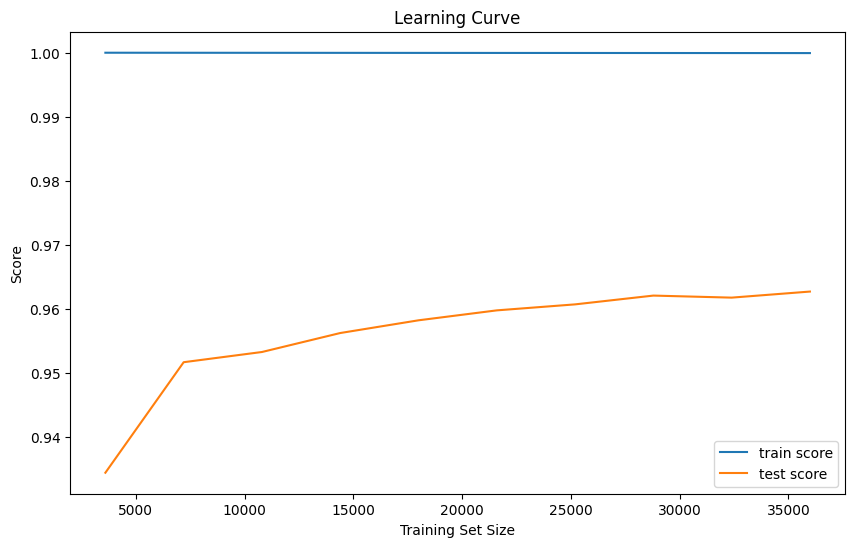

In [ ]:
def plot_learning_curve(model,cv=10):
  N,train_scores,test_scores=learning_curve(model,X_train,y_train,cv=cv,train_sizes=np.linspace(0.1,1,10))
  plt.figure(figsize=(10,6))
  plt.plot(N,train_scores.mean(axis=1),label="train score")
  plt.plot(N,test_scores.mean(axis=1),label="test score")
  plt.title("Learning Curve")
  plt.xlabel("Training Set Size")
  plt.ylabel("Score")
  plt.grid
  plt.legend()
  plt.show()

plot_learning_curve(decision_tree)

Interpretation: Our model suffers from overfitting because it is over-learning from the training set. This results in a perfect score during training and a test score that increases slowly. The model may be too complex.

To address this, we will add regularization hyperparameters (max_depth, min_samples_split) to the model to limit its depth.

In [ ]:
tree_reg2 = DecisionTreeRegressor(max_depth=10, min_samples_split=20, min_samples_leaf=10)
decision_tree2 = make_pipeline(transformer_tree,tree_reg2)
cv_tree_reg2 = cross_val_score(decision_tree2,X_train,y_train,cv=10)
print(cv_tree_reg2)
print("Mean Decision Tree Score:" , cv_tree_reg2.mean())

[0.96984959 0.96739601 0.97182886 0.9713529  0.97145925 0.97013085
 0.97236414 0.96681685 0.95944749 0.97156739]
Mean Decision Tree Score: 0.9692213341803461


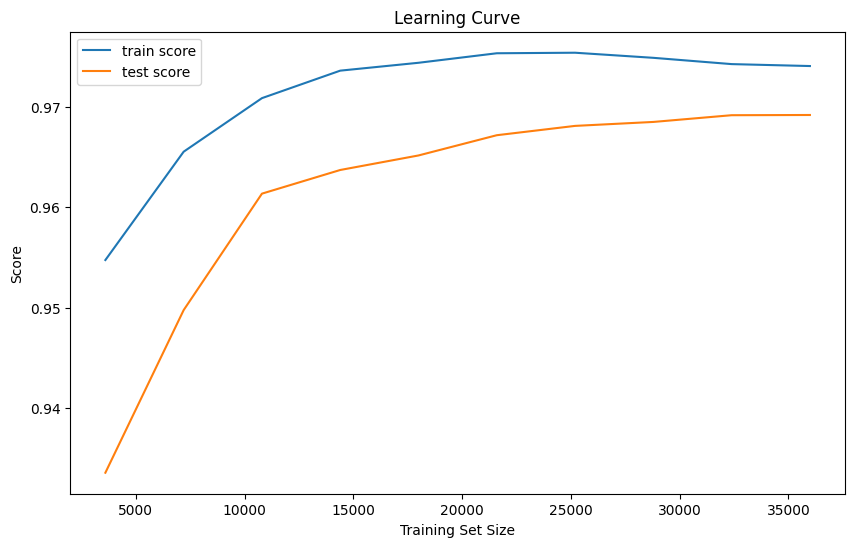

In [ ]:
plot_learning_curve(decision_tree2)

This time, both curves converge to a good score with a large dataset size. The model is likely well-tuned. It just remains to fine-tune the hyperparameters.

**Knn**

In [ ]:
knn=make_pipeline(transformer,knn_reg)

cv_knn=cross_val_score(knn,X_train,y_train,cv=10)
print(cv_knn)
print("Mean KNN Score:" , cv_knn.mean())

[0.94590814 0.93997066 0.94711519 0.94584309 0.94815491 0.94549684
 0.9437521  0.94098862 0.93863406 0.94602079]
Mean KNN Score: 0.9441884408174218


We also have very good results here. It would be very interesting to tune it.

**Gradient Boosting method**

Let's try testing the Gradient Boosting method.

In [ ]:
gradient_reg =GradientBoostingRegressor(max_depth=3, n_estimators=100, learning_rate=0.1, random_state=42)
decision_gradient=make_pipeline(transformer,gradient_reg)
cv_grad_reg = cross_val_score(decision_gradient,X_train,y_train,cv=10)
print(cv_grad_reg)
print("Mean Gradient Boosting Score:" , cv_grad_reg.mean())

[0.96876354 0.96908546 0.97148104 0.97005826 0.97116948 0.97033775
 0.97177524 0.96808487 0.95841997 0.97162833]
Mean Gradient Boosting Score: 0.9690803940246917


We observe a good score for the Gradient Boosting method.

###Comparison of Different Models

In [ ]:
def compare(cv1,cv2,name1,name2):
  scores = cv1-cv2
  s=0
  for i in scores :
    if i>0:
      s+=1
    #return s
  if s>len(scores) / 2:
    print(f"{name1} is better {s} time than {name2}")
  elif s<len(scores) / 2:
    print(f"{name2} is better {len(scores)- s} time than {name1}")


In [ ]:
compare(cv_lin_reg,cv_ridge,'linear regression','ridge')
compare(cv_lin_reg,cv_tree_reg2,'linear regression','decision tree2')
compare(cv_lin_reg,cv_knn,'linear regression','knn')
compare(cv_ridge,cv_tree_reg2,'ridge','decision tree2')
compare(cv_ridge,cv_knn,'ridge','knn')
compare(cv_tree_reg2,cv_knn,'decision tree2','knn')
compare(cv_tree_reg2,cv_tree_reg,'decision tree2','decision tree')
compare(cv_grad_reg,cv_ridge,'gradient boosting','ridge')
compare(cv_grad_reg,cv_lin_reg,'gradient boosting','linear regression')
compare(cv_grad_reg,cv_knn,'gradient boosting','knn')
compare(cv_grad_reg,cv_tree_reg2,'gradient boosting','decision tree2')


decision tree2 is better 10 time than linear regression
knn is better 10 time than linear regression
decision tree2 is better 10 time than ridge
knn is better 10 time than ridge
decision tree2 is better 10 time than knn
decision tree2 is better 10 time than decision tree
gradient boosting is better 10 time than ridge
gradient boosting is better 10 time than linear regression
gradient boosting is better 10 time than knn
decision tree2 is better 6 time than gradient boosting


The Decision Tree model is still better than all the other models.

##Fine-Tune Our Model

###Hyperparameter Tuning and Analysis


Let's start by improving linear regression.

Let's use the ElasticNet method, which is a regression technique that combines L1 (Lasso) and L2 (Ridge) regularization.

In [ ]:
elastic_net=make_pipeline(
    transformer,
    ElasticNet()
)
param = {
    'elasticnet__alpha' : [10,1,1e-1,1e-2],
    'elasticnet__l1_ratio' : [1,0.75,0.5,0.25,0]
}
grid_en=GridSearchCV(elastic_net,param,cv=10)
grid_en.fit(X_train,y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.657e+11, tolerance: 5.786e+07 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.666e+11, tolerance: 5.781e+07 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_mode

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('standardscaler',
                                                                         StandardScaler(),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7cb2a458b610>),
                                                                        ('ordinalencoder',
                                                                         OrdinalEncoder(categories=[['Fair',
                                                                                                     'Good',
                                                                                                     'Very '
                                                                                                     'Good',
                                                                                                     'Premium',
                                                                                                     'Ideal'],
                                                                                                    ['I1',
                                                                                                     'SI2',
                                                                                                     'SI1',
                                                                                                     'VS2',
                                                                                                     'VS1',
                                                                                                     'VVS2',
                                                                                                     'VVS1',
                                                                                                     'IF']]),
                                                                         ['cut',
                                                                          'clarity']),
                                                                        ('onehotencoder',
                                                                         OneHotEncoder(),
                                                                         ['color'])])),
                                       ('elasticnet', ElasticNet())]),
             param_grid={'elasticnet__alpha': [10, 1, 0.1, 0.01],
                         'elasticnet__l1_ratio': [1, 0.75, 0.5, 0.25, 0]})

In [ ]:
grid_en.best_params_,grid_en.best_score_

({'elasticnet__alpha': 0.01, 'elasticnet__l1_ratio': 0.25}, 0.8377479697230699)

With an L1 ratio of 0.25, we are favoring Ridge regularization more. Additionally, with an alpha of 0.01, the effect of regularization is reduced. However, this can lead to overfitting.

Now, let's try to improve the Ridge method.

In [ ]:
alphas = [0.01, 0.1, 1.0, 10.0, 100.0,250.0,269.0,268.0, 500.0, 1000.0]

ridge_cv = RidgeCV(alphas=alphas, cv=5)

ridge_cv.fit(X_train_prepared, y_train)

best_alpha = ridge_cv.alpha_
print("Best alpha:", best_alpha)

ridge_cv_predictions = ridge_cv.predict(X_test_prepared)

ridge_cv_r2 = r2_score(y_test, ridge_cv_predictions)

print("RidgeCV - Best Alpha:", best_alpha)
print("RidgeCV - R² Score:", ridge_cv_r2)

Best alpha: 268.0
RidgeCV - Best Alpha: 268.0
RidgeCV - R² Score: 0.9035427611886121


We find that the model performs best with an alpha value of 268.

Even though we are satisfied with the Decision Tree model's results, let's try to see if we can still improve the model. Let's search for the best parameters for max_depth, min_samples_split, min_samples_leaf, and max_features that could improve the model.

In [ ]:
param_grid = {
    'max_depth' : [None, 10, 20, 30],
    'min_samples_split' : [2,5,10],
    'min_samples_leaf' : [1,2,5],
    'max_features' : [None,'sqrt','log2']

}

grid_tree = GridSearchCV(tree_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)
grid_tree.fit(X_train_prepared, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeRegressor(random_state=42),
             param_grid={'max_depth': [None, 10, 20, 30],
                         'max_features': [None, 'sqrt', 'log2'],
                         'min_samples_leaf': [1, 2, 5],
                         'min_samples_split': [2, 5, 10]},
             return_train_score=True, scoring='neg_mean_squared_error')

In [ ]:
grid_tree.best_params_,grid_tree.best_estimator_

({'max_depth': 20,
  'max_features': None,
  'min_samples_leaf': 5,
  'min_samples_split': 2},
 DecisionTreeRegressor(max_depth=20, min_samples_leaf=5, random_state=42))

Let's now try to improve the KNN model. Let's test two method to find the best n_neughbors.

In [ ]:
k_values=range(1,21)
cv_scores=[]

for k in k_values:
  knn_reg = KNeighborsRegressor(n_neighbors=k)
  scores = cross_val_score(knn_reg, X_train_prepared, y_train, cv=5)
  cv_scores.append(scores.mean())

best_k = k_values[cv_scores.index(min(cv_scores))]
print('Best k :' ,best_k)

Best k : 1


In [ ]:
param_knn={
    'kneighborsregressor__n_neighbors' : range(1,21)
}

grid_knn=GridSearchCV(knn,param_knn,cv=5)
grid_knn.fit(X_train,y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('standardscaler',
                                                                         StandardScaler(),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7cb2a458b610>),
                                                                        ('ordinalencoder',
                                                                         OrdinalEncoder(categories=[['Fair',
                                                                                                     'Good',
                                                                                                     'Very '
                                                                                                     'Good',
                                                                                                     'Premium',
                                                                                                     'Ideal'],
                                                                                                    ['I1',
                                                                                                     'SI2',
                                                                                                     'SI1',
                                                                                                     'VS2',
                                                                                                     'VS1',
                                                                                                     'VVS2',
                                                                                                     'VVS1',
                                                                                                     'IF']]),
                                                                         ['cut',
                                                                          'clarity']),
                                                                        ('onehotencoder',
                                                                         OneHotEncoder(),
                                                                         ['color'])])),
                                       ('kneighborsregressor',
                                        KNeighborsRegressor(n_neighbors=10))]),
             param_grid={'kneighborsregressor__n_neighbors': range(1, 21)})

In [ ]:
grid_knn.best_params_,grid_knn.best_score_

({'kneighborsregressor__n_neighbors': 6}, 0.9431424081234017)

Depending on the two methods, we find a different number of neighbors. This can be explained by the fact that the **cross_val_score** and **GridSearchCV** methods evaluate performance differently, which can lead to different selections. Indeed, **cross_val_score** measures the mean squared error, while **GridSearchCV** maximizes the R² score.

Let's test for these values with n_neighbors=6 and n_neighbors=1.


In [ ]:
def comparaison_knn(n_neighbors):
  knn_reg = KNeighborsRegressor(n_neighbors=n_neighbors)
  knn=make_pipeline(transformer,knn_reg)
  cv_knn=cross_val_score(knn,X_train,y_train,cv=10)
  return cv_knn

compare(comparaison_knn(6),comparaison_knn(1),'Knn with n_neighbors=6','Knn with n_neighbors=1')

Knn with n_neighbors=6 is better 10 time than Knn with n_neighbors=1


We observe that we have better predictions for n_neighbors=6 rather than for n_neighbors=1. We will keep n_neighbors=6.

The Gradient Boosting method is very slow to improve, so we have decided not to consider this method, even though it gives very good scores.

###Comparaison

In [ ]:
tree_reg3 = DecisionTreeRegressor(max_depth=20, min_samples_split=2, min_samples_leaf=5)
decision_tree3 = make_pipeline(transformer_tree,tree_reg3)
cv_tree_reg3 = cross_val_score(decision_tree3,X_train,y_train,cv=10)

compare(cv_tree_reg2,cv_tree_reg3,'decision tree 2','decision tree 3')

decision tree 3 is better 9 time than decision tree 2


In [ ]:
knn2 = make_pipeline(transformer,KNeighborsRegressor(n_neighbors=6))

cv_knn2=cross_val_score(knn2,X_train,y_train,cv=10)
compare(cv_knn2,cv_knn,'knn2','knn')

knn2 is better 8 time than knn


In [ ]:
elastic_net2=make_pipeline(
    transformer,
    ElasticNet(alpha=0.01,l1_ratio=0.25)
)
cv_en=cross_val_score(elastic_net2,X_train,y_train,cv=10)
print(cv_en)
compare(cv_en,cv_lin_reg,'elastic net','linear regression')

[0.32001665 0.90173355 0.89546406 0.89971854 0.90283849 0.90659888
 0.89439326 0.9025543  0.85381197 0.90035001]


Even with an improvement in the Elastic Net method, it is less performant than the other models.

##Analyze the Best Models and Their Errors

###Ensemble Method

After all the improvements, the tree models remain the best prediction method. Let's now test the ensemble methods: Voting Classifier and Stacking Method.
   
**Voting classifer**

In [ ]:
vot_regressor=VotingRegressor([('KNN',knn2),("Linear Regression",linear_regression),('Decision Tree',decision_tree3)])
cv_vot_regressor=cross_val_score(vot_regressor,X_train,y_train,cv=10)
print(cv_vot_regressor)
print("Mean Vot Regressor Score:" , cv_vot_regressor.mean())

[0.89949765 0.96311742 0.96494438 0.96429128 0.96632853 0.96512243
 0.96432443 0.96267694 0.94633032 0.96388363]
Mean Vot Regressor Score: 0.9560517018439099


Comparison :

In [ ]:
compare(cv_vot_regressor,cv_knn2,'vot regressor','knn2')
compare(cv_vot_regressor,cv_tree_reg3,'vot regressor','decision tree3')
compare(cv_vot_regressor,cv_lin_reg,'vot regressor','decision tree3')

vot regressor is better 9 time than knn2
decision tree3 is better 10 time than vot regressor
vot regressor is better 10 time than decision tree3


Decision Tree remains the best method.

**Stacking method**

In [ ]:
from sklearn.ensemble import StackingRegressor
stack_regressor=StackingRegressor([('KNN',knn2),("Linear Regression",linear_regression),('Decision Tree',decision_tree3)])
cv_stack_regressor=cross_val_score(stack_regressor,X_train,y_train,cv=10)
print(cv_stack_regressor)
print("Mean Stack Regressor:" , cv_stack_regressor.mean())

[0.97120522 0.97416928 0.97715139 0.97670347 0.97789463 0.97524146
 0.97665882 0.97090746 0.96499018 0.97492429]
Mean Stack Regressor: 0.9739846198011122


In [ ]:
compare(cv_stack_regressor,cv_knn2,'stack regressor','knn2')
compare(cv_stack_regressor,cv_tree_reg3,'stack regressor','decision tree3')
compare(cv_stack_regressor,cv_lin_reg,'stack regressor','decision tree3')
compare(cv_vot_regressor,cv_stack_regressor,'vot regressor','stack regressor')

stack regressor is better 10 time than knn2
stack regressor is better 10 time than decision tree3
stack regressor is better 10 time than decision tree3
stack regressor is better 10 time than vot regressor


The stacking method is 11 times slower than the voting model but provides better results than all the other models.

#Evaluate Our System on the Test Set

In [ ]:
stack_regressor.fit(X_train,y_train)

StackingRegressor(estimators=[('KNN',
                               Pipeline(steps=[('columntransformer',
                                                ColumnTransformer(transformers=[('standardscaler',
                                                                                 StandardScaler(),
                                                                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7cb2a458b610>),
                                                                                ('ordinalencoder',
                                                                                 OrdinalEncoder(categories=[['Fair',
                                                                                                             'Good',
                                                                                                             'Very '
                                                                                                             'Good',
                                                                                                             'Premium',
                                                                                                             'Ideal'],
                                                                                                            ['I1',
                                                                                                             'SI2',
                                                                                                             'SI1',
                                                                                                             'VS2',
                                                                                                             'VS1',
                                                                                                             'VVS2...
                                                                                 ['color'])])),
                                               ('linearregression',
                                                LinearRegression())])),
                              ('Decision Tree',
                               Pipeline(steps=[('columntransformer',
                                                ColumnTransformer(remainder='passthrough',
                                                                  transformers=[('ordinalencoder',
                                                                                 OrdinalEncoder(),
                                                                                 ['cut',
                                                                                  'clarity']),
                                                                                ('onehotencoder',
                                                                                 OneHotEncoder(),
                                                                                 ['color'])])),
                                               ('decisiontreeregressor',
                                                DecisionTreeRegressor(max_depth=20,
                                                                      min_samples_leaf=5))]))])

In [ ]:
print(stack_regressor.score(X_test,y_test),stack_regressor.score(X_train,y_train))

0.9756919334745549 0.9877538095454496


Very good score on the test, very close to the train.

Let's see what the RMSE gives.

In [ ]:
y_pred=stack_regressor.predict(X_test)
error = mean_squared_error(y_test,y_pred)**(0.5)
print(error)

620.9592860913684


In [ ]:
for i in range(1,10):
  print('test : ',y_test.iloc[i],',predict : ', y_pred[i])

test :  367 ,predict :  358.78986367166715
test :  1154 ,predict :  1044.0213942833996
test :  2012 ,predict :  1871.1632447525326
test :  9954 ,predict :  11092.085800536395
test :  4672 ,predict :  4153.605455683952
test :  3091 ,predict :  3642.62823722043
test :  720 ,predict :  662.1819988966303
test :  7677 ,predict :  7240.242095284526
test :  684 ,predict :  636.0868125604421


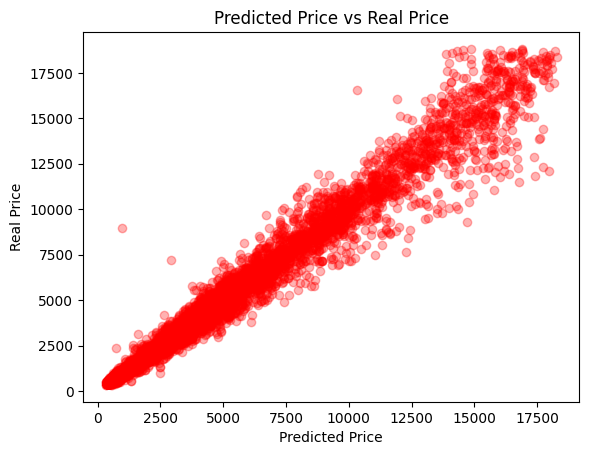

In [ ]:
plt.figure()
plt.scatter(x=y_pred,y=y_test,c='red',alpha=0.3)
plt.xlabel('Predicted Price')
plt.ylabel('Real Price')
plt.title('Predicted Price vs Real Price')
plt.show()


In the end, we have very satisfactory predictions, even though we observe that for higher values, we are less precise.